# Project-3: Анализ воронки продаж пользователям в мобильном приложении

Мобильное приложение - игра Quiz Freeze. Это сборник вопросов в различных форматах и темах, на которые игрокам нужно давать ответы. Игра одиночная, то есть каждый игрок отвечает на вопросы самостоятельно.
Некоторое время назад игру основательно переделали, но хороший и качественный анализ изменений, к сожалению, до сих пор не провели.

Необходимо провести анализ поведения пользователей, чтобы понять как пользователи взаимодействуют с приложение.

## Цель: Исследовать поведение пользователей в обновленном приложении Quiz Freeze

Гипотеза 1: Должна быть разница в поведении групп, которые проходят и не проходят обучение. Так ли это? Влияет ли обучение на скорость прохождения других этапов игры?

Гипотеза 2: Повторное прохождение обучения положительно влияет на оплату, так ли это?

Гипотеза 3: Если пользователь сначала выбирает сложность обучения, будет ли он потом проходить обучение?

Задачи:
1. Определить, насколько обучение сокращает время прохождения этапов игры.
2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
3. Определить, насколько прозрачен процесс взаимодействия с игрой.

In [1]:
# загружаем необходимые библиотеки
import pandas as pd

import plotly
import plotly.express as px
from plotly import graph_objects as go
import plotly.io as pio

from IPython.display import Image

In [2]:
# читаем данные
events = pd.read_csv('7_4_Events.csv')
purchases = pd.read_csv('purchase.csv')

In [3]:
# создаем условие для отбора пользователей,
# зарегистрировавшихся в приложении в 2018 г.
users_condition = ((events['start_time'] >= '2018-01-01') 
                   & (events['start_time'] < '2019-01-01') 
                   & (events['event_type'] == 'registration'))

users_list = events[users_condition]['user_id'].to_list()
events = events[
    events['user_id'].isin(users_list)].copy()#применен метод copy для явного копирования и избежания предупреждений
# преобразуем типы данных и создаем дополнительные признаки
events['start_time'] = pd.to_datetime(events['start_time'])
events['event_type'] = events['event_type'].astype('category')  
events['selected_level'] = events['selected_level'].astype('category')
events = events.rename(
    columns={'id': 'event_id'}
)

purchases = purchases[purchases['user_id'].isin(users_list)].copy()#применен метод copy для явного копирования и избежания предупреждений
purchases = purchases.rename(
    columns={'event_datetime': 'start_time', 'id': 'event_id'}
)
purchases['start_time'] = pd.to_datetime(purchases['start_time'])
purchases['event_type'] = 'purchase'
purchases['event_type'] = purchases['event_type'].astype('category')

In [4]:
# создаем общий DataFrame
df = pd.concat(
    [events, purchases], 
    sort=False
)
df = df.reset_index(drop=True).sort_values('start_time')
df['event_type'] = df['event_type'].astype('category')
# закрепляем последовательность этапов приложения, 
# чтобы этапы корректно отображались в воронке
df['event_type'].cat.set_categories(
    ['registration', 'tutorial_start', 'tutorial_finish', 
    'level_choice', 'pack_choice', 'purchase'], inplace=True) 

c:\Users\karin\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arrays\categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [5]:
# проверка
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68559 entries, 0 to 68558
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   event_id        68559 non-null  int64         
 1   event_type      68559 non-null  category      
 2   selected_level  8342 non-null   category      
 3   start_time      68559 non-null  datetime64[ns]
 4   tutorial_id     32954 non-null  float64       
 5   user_id         68559 non-null  int64         
 6   amount          1600 non-null   float64       
dtypes: category(2), datetime64[ns](1), float64(2), int64(2)
memory usage: 3.3 MB


# Проверка Гипотезы 1

## 1.1 Для провнрки Гипотезы о том, что время прохожденя скорости этапов приложения может различаться у разных групп пользователей, выделим группы пользователей, которые окончили обучение, не начинали обучение, начинали обучение, но не закончили его.

In [6]:
# определяем общее количество пользователей
all_users_cnt = df['user_id'].nunique()
print('Общее количество пользователей:', all_users_cnt)
print()
# определяем количество пользователей, 
# которые завершили обучение
condition_1 = df['event_type'] == 'tutorial_finish'
tutorial_finished_users = df[condition_1]['user_id'].unique()
print('Количество пользователей, окончивших этап \
обучения:', len(tutorial_finished_users)
)
print('Процент пользователей, окончивших обучение, от общего числа\
пользователей: {:.2%}'.format(
    len(tutorial_finished_users)/all_users_cnt)
)
print()

# определяем количество пользователей, 
# которые начинали обучение, но не завершили его
condition_2 = ((df['event_type'] == 'tutorial_start') 
               & (~df['user_id'].isin(tutorial_finished_users)))
tutorial_not_finished_users = df[condition_2]['user_id'].unique()
print('Количество пользователей, начинавших, \
но не окончивших этап обучения:', len(tutorial_not_finished_users)
)
print('Процент пользователей, начинавших, но не окончивших \
обучение, от общего числа пользователей: {:.2%}'.format(
    len(tutorial_not_finished_users)/all_users_cnt)
)
print()

# определяем количество пользователей, которые не начинали обучение
tutorial_start_users = df[
    df['event_type'] == 'tutorial_start']['user_id'].unique()
condition_3 = (~df['user_id'].isin(tutorial_start_users))
tutorial_not_started_users = df[condition_3]['user_id'].unique()

print('Количество пользователей, \
не начинавших этап обучения:', len(tutorial_not_started_users)
)
print('Процент пользователей, не начинавших обучение, от общего числа \
пользователей: {:.2%}'.format(
    len(tutorial_not_started_users)/all_users_cnt)
)

Общее количество пользователей: 19926

Количество пользователей, окончивших этап обучения: 10250
Процент пользователей, окончивших обучение, от общего числапользователей: 51.44%

Количество пользователей, начинавших, но не окончивших этап обучения: 1608
Процент пользователей, начинавших, но не окончивших обучение, от общего числа пользователей: 8.07%

Количество пользователей, не начинавших этап обучения: 8068
Процент пользователей, не начинавших обучение, от общего числа пользователей: 40.49%


In [7]:
# проверяем соответствие количества пользователей по выделенным группам 
# общему числу пользователей
print(all_users_cnt == len(tutorial_finished_users) 
      + len(tutorial_not_finished_users) 
      + len(tutorial_not_started_users))

True


Примерно 60% от общего числа пользователей начинают этап прохождения обучения. Более половины от всех пользователей заканчивают.
Около 40% пользоваелей не приступают к обучению. 

In [8]:
# создаем функцию для определения принадлежности каждого 
# пользователя к группам по прохождению обучения
def get_tutorial_status(user_id):
    if user_id in tutorial_finished_users:
        return 'tut_finished'
    elif user_id in tutorial_not_finished_users:
        return 'tut_not_finished'
    elif user_id in tutorial_not_started_users:
        return 'tut_not_started'


df['tutorial_status'] = df['user_id'].apply(get_tutorial_status)

In [9]:
# создаем сводную таблицу со всеми этапами 
# приложения и пользователями поделенными по группам
group_pivot = pd.pivot_table(
    data=df,
    values=['user_id'],
    columns=['tutorial_status'],
    index=['event_type'],
    aggfunc='nunique'
)
group_pivot.columns = list(
    map(lambda x: x[-1], group_pivot)
)
group_pivot = group_pivot.reset_index()
# создаем дополнительные признаки, отображающие общее 
# количество пользователей и процентное соотношение от общего числа
group_pivot['all_users'] = group_pivot['tut_finished'] + group_pivot['tut_not_started'] + group_pivot['tut_not_finished']

group_pivot['tut_finished_%'] = round(
    group_pivot['tut_finished'] / group_pivot['all_users'], 2
)
group_pivot['tut_not_finished_%'] = round(
    group_pivot['tut_not_finished'] / group_pivot['all_users'], 2
)
group_pivot['tut_not_started_%'] = round(
    group_pivot['tut_not_started'] / group_pivot['all_users'], 2
)
group_pivot

,event_type,tut_finished,tut_not_finished,tut_not_started,all_users,tut_finished_%,tut_not_finished_%,tut_not_started_%
0,registration,10250,1608,8068,19926,0.51,0.08,0.40
1,tutorial_start,10250,1608,0,11858,0.86,0.14,0.00
2,tutorial_finish,10250,0,0,10250,1.00,0.00,0.00
3,level_choice,7501,743,98,8342,0.90,0.09,0.01
4,pack_choice,5176,487,74,5737,0.90,0.08,0.01
5,purchase,1447,131,22,1600,0.90,0.08,0.01


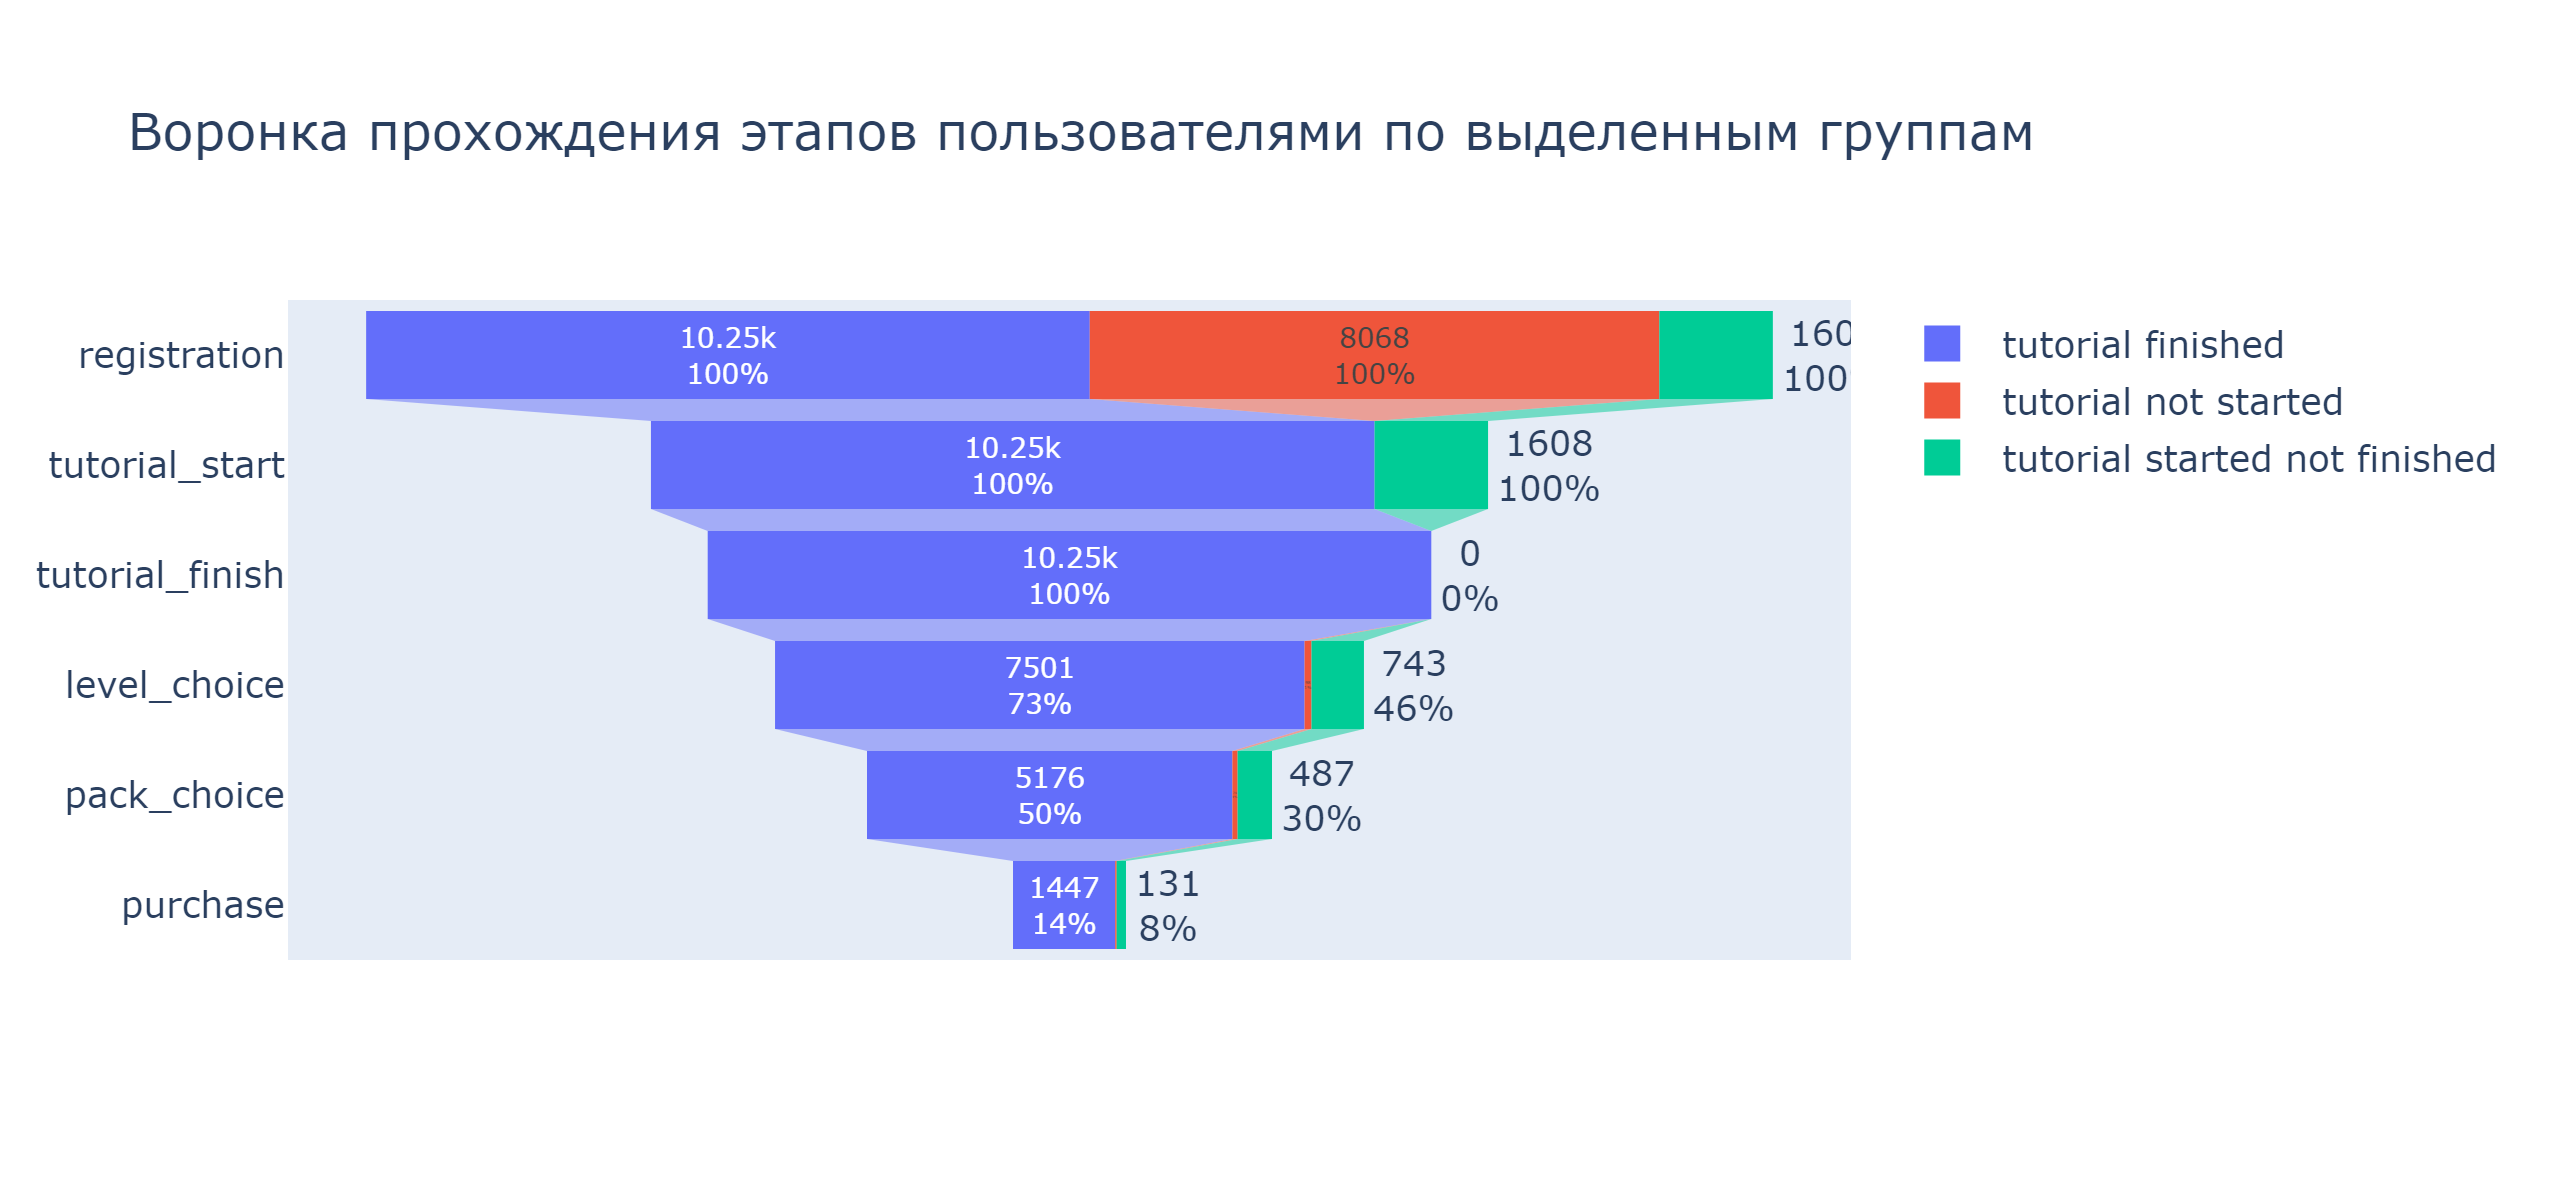

In [10]:
# импортирую необходимую библиотеку для создания воронки
from plotly import graph_objects as go
# создаем воронку пользователей, включающую группы пользователей
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'tutorial finished',
    y = group_pivot['event_type'],
    x = group_pivot['tut_finished'].values,
    textinfo = 'value+percent initial'))

fig.add_trace(go.Funnel(
    name = 'tutorial not started',
    orientation = 'h',
    y = group_pivot['event_type'],
    x = group_pivot['tut_not_started'].values,
    textposition = 'inside',
    textinfo = 'value+percent initial'))

fig.add_trace(go.Funnel(
    name = 'tutorial started not finished',
    orientation = 'h',
    y = group_pivot['event_type'],
    x = group_pivot['tut_not_finished'].values,
    textposition = 'outside',
    textinfo = 'value+percent initial'))

fig.update_layout(title_text='Воронка прохождения этапов пользователями по выделенным группам')

img = fig.to_image(format="png", width=850, height=400, scale=3, engine="orca")
Image(img)

Больше половины пользователей прошли этап обучения и именно эти пользователи составляют большинство тех (~90%), кто проходит на следующие этапы приложения и доходят до этапа оплаты вопросов.

Наименьшее число пользователей, совершивших покупку вопросов, относится к тем, кто не начинал обучение. Лишь 0,3% от числа этих пользователей доходят до этапа покупки вопросов.

Таким образом, подтверждается прямая зависимость вероятности оплаты от прохождения обучения.

## 1.2 Проверяем как различается время прохождения этапов приложения Quiz Freez пользователями выделенных групп

In [11]:
# определяем этапы приложения
evs = df['event_type'].unique().tolist()

print("Этапы прохождения приложения \
Quiz Freeze:", ', '.join(evs)
)

Этапы прохождения приложения Quiz Freeze: registration, tutorial_start, tutorial_finish, level_choice, pack_choice, purchase


In [12]:
# определяем воронку прохождения этапов всеми пользователями
events_grouped = df.groupby(
    ['event_type']
)['user_id'].nunique()

print('Изменение общего количества пользователей на \
разных этапах приложения Quiz Freeze:')
events_grouped.sort_values(ascending=False)

Изменение общего количества пользователей на разных этапах приложения Quiz Freeze:


event_type
registration       19926
tutorial_start     11858
tutorial_finish    10250
level_choice        8342
pack_choice         5737
purchase            1600
Name: user_id, dtype: int64

In [13]:
# Создаем сводную таблицу со временем начала 
# прохождения пользователями этапов приложения
time_pivot_table = df.pivot_table(
    values=['start_time'],
    index=['user_id'],
    columns=['event_type'],
    aggfunc='min'
)
time_pivot_table.columns = list(
    map(lambda x: x[-1], time_pivot_table)
)
time_pivot_table = time_pivot_table.reset_index()
time_pivot_table['tutorial_status'] = time_pivot_table['user_id'].apply(get_tutorial_status)
time_pivot_table.head()

,user_id,registration,tutorial_start,tutorial_finish,level_choice,pack_choice,purchase,tutorial_status
0,27832,2018-01-01 03:48:40,NaT,NaT,NaT,NaT,NaT,tut_not_started
1,27833,2018-01-01 04:07:25,2018-01-01 17:47:40,2018-01-01 17:50:08,NaT,NaT,NaT,tut_finished
2,27834,2018-01-01 08:35:10,2018-01-01 19:46:11,2018-01-01 19:48:01,NaT,NaT,NaT,tut_finished
3,27835,2018-01-01 11:54:47,2018-01-01 15:00:51,2018-01-01 15:06:15,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,tut_finished
4,27836,2018-01-01 13:28:07,2018-01-01 14:54:40,2018-01-01 15:42:58,NaT,NaT,NaT,tut_finished


In [14]:
# создаем сводную таблицу с данными о пользователях, 
# окончивших обучение
tfu_time_table = time_pivot_table[
    time_pivot_table['tutorial_status'] == 'tut_finished'].copy() # копируем для издежания SettingWithCopyWarning

# создаем признаки timedelta между этапами приложения
tfu_time_table['reg_tut_start_timedelta'] = tfu_time_table['tutorial_start'] - tfu_time_table['registration']
tfu_time_table['tut_start_tut_finish_timedelta'] = tfu_time_table['tutorial_finish'] - tfu_time_table['tutorial_start']
tfu_time_table['tut_finish_level_choice_timedelta'] = tfu_time_table['level_choice'] - tfu_time_table['tutorial_finish']
tfu_time_table['level_pack_choices_timedelta'] = tfu_time_table['pack_choice'] - tfu_time_table['level_choice']
tfu_time_table['pack_choice_purchase_timedelta'] = tfu_time_table['purchase'] - tfu_time_table['pack_choice']
tfu_time_table['reg_purchase_timedelta'] = tfu_time_table['purchase'] - tfu_time_table['registration']

In [15]:
# выводим среднее значение времени прохождения 
# этапов приложения пользователями завершившими обучение
tfu_bar_data = tfu_time_table[
    ['reg_tut_start_timedelta', 
    'tut_start_tut_finish_timedelta', 
    'tut_finish_level_choice_timedelta', 
    'level_pack_choices_timedelta', 
    'pack_choice_purchase_timedelta']
].mean()

print('Среднее время прохождения этапов приложения \
от регистрации до покупки у пользователей, завершивших \
обучение:', tfu_time_table['reg_purchase_timedelta'].mean()
)

tfu_bar_data

Среднее время прохождения этапов приложения от регистрации до покупки у пользователей, завершивших обучение: 4 days 00:30:03.247408431


reg_tut_start_timedelta             0 days 04:31:04.938146341
tut_start_tut_finish_timedelta      0 days 00:12:13.823121951
tut_finish_level_choice_timedelta   0 days 02:19:46.959472070
level_pack_choices_timedelta        0 days 00:05:18.146058732
pack_choice_purchase_timedelta      3 days 17:17:59.641326883
dtype: timedelta64[ns]

In [16]:
# создаем сводную таблицу с данными о пользователях, 
# которые не начинали проходить обучение
tns_time_table = time_pivot_table[
    time_pivot_table['tutorial_status'] == 'tut_not_started'].copy() # копируем для издежания SettingWithCopyWarning
# удаляем столбцы, где все значения пустые
tns_time_table.dropna(
    axis=1, 
    how='all', 
    inplace=True
)
# создаем признаки timedelta между пройденными 
# этапами группой пользователей
tns_time_table['reg_level_choice_timedelta'] = tns_time_table['level_choice'] - tns_time_table['registration']
tns_time_table['level_pack_choices_timedelta'] = tns_time_table['pack_choice'] - tns_time_table['level_choice']
tns_time_table['pack_choice_purchase_timedelta'] = tns_time_table['purchase'] - tns_time_table['pack_choice']
tns_time_table['reg_purchase_timedelta'] = tns_time_table['purchase'] - tns_time_table['registration']

In [17]:
# выводим среднее время прохождения этапов 
# приложения пользователями не начинавшими обучение
tns_bar_data = tns_time_table[
    ['reg_level_choice_timedelta', 
    'level_pack_choices_timedelta', 
    'pack_choice_purchase_timedelta']
].mean()

print('Среднее время прохождения этапов приложения от \
регистрации до покупки у пользователей, не начинавших \
обучение:', tns_time_table['reg_purchase_timedelta'].mean()
)

tns_bar_data

Среднее время прохождения этапов приложения от регистрации до покупки у пользователей, не начинавших обучение: 4 days 09:06:01.909090909


reg_level_choice_timedelta       0 days 05:15:33.122448979
level_pack_choices_timedelta     0 days 00:05:23.824324324
pack_choice_purchase_timedelta   4 days 04:49:33.590909090
dtype: timedelta64[ns]

In [18]:
# создаем сводную таблицу с данными о пользователях, 
# которые не окончили обучение
tnf_time_table = time_pivot_table.loc[
    time_pivot_table['tutorial_status'] == 'tut_not_finished'].copy() # копируем для издежания SettingWithCopyWarning
# удаляем столбец, где все значения пустые
tnf_time_table.dropna(
    axis=1, 
    how='all', 
    inplace=True
)
# создаем признаки timedelta между 
# пройденными этапами группой пользователей
tnf_time_table['reg_tut_start_timedelta'] = tnf_time_table['tutorial_start'] - tnf_time_table['registration']
tnf_time_table['tut_start_level_choice_timedelta'] = tnf_time_table['level_choice'] - tnf_time_table['tutorial_start']
tnf_time_table['level_pack_choices_timedelta'] = tnf_time_table['pack_choice'] - tnf_time_table['level_choice']
tnf_time_table['pack_choice_purchase_timedelta'] = tnf_time_table['purchase'] - tnf_time_table['pack_choice']
tnf_time_table['reg_purchase_timedelta'] = tnf_time_table['purchase'] - tnf_time_table['registration']

In [19]:
# выводим среднее время прохождения этапов
tnf_bar_data = tnf_time_table[
    ['reg_tut_start_timedelta', 
    'tut_start_level_choice_timedelta', 
    'level_pack_choices_timedelta', 
    'pack_choice_purchase_timedelta']
].mean()

print('Среднее время прохождения этапов приложения от \
регистрации до покупки у пользователей, не завершивших обучение\
:', tnf_time_table['reg_purchase_timedelta'].mean()
)

tnf_bar_data

Среднее время прохождения этапов приложения от регистрации до покупки у пользователей, не завершивших обучение: 4 days 05:32:53.213740458


reg_tut_start_timedelta            0 days 05:25:02.892412935
tut_start_level_choice_timedelta   0 days 02:47:28.088829071
level_pack_choices_timedelta       0 days 00:05:05.295687885
pack_choice_purchase_timedelta     3 days 21:14:46.908396946
dtype: timedelta64[ns]

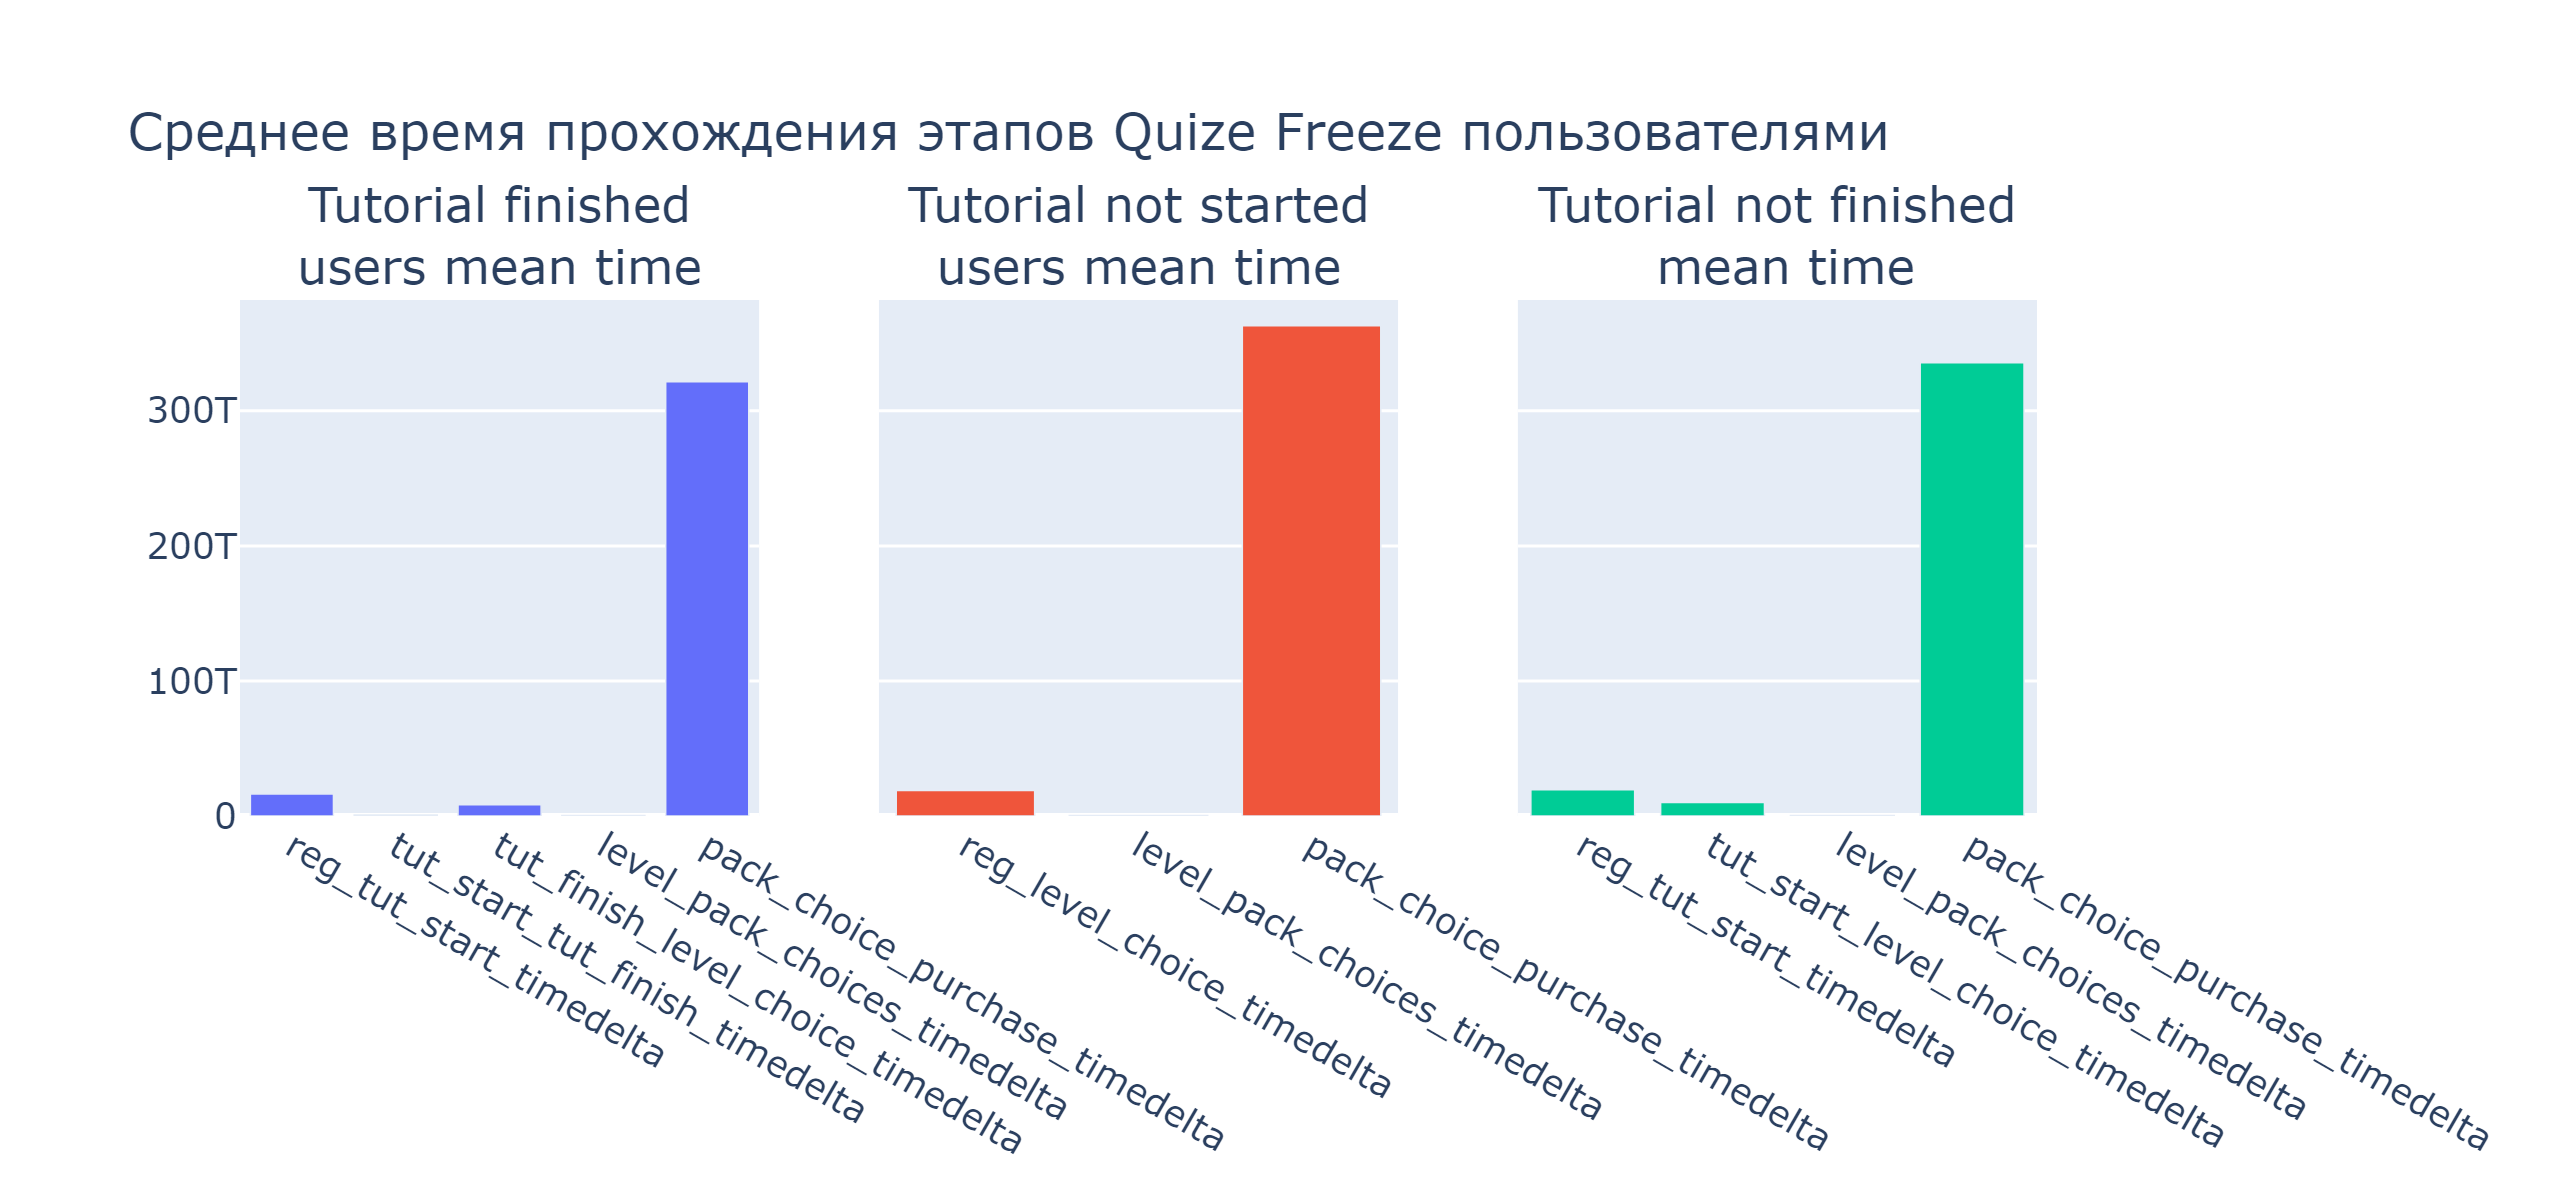

In [20]:
# загружаем plotly.subplots для отображения 
# нескольких графиков для каждой группы пользователей
from plotly.subplots import make_subplots

# создаем столбчатые диаграммы отображающие 
# среднее время прохождения этапов приложения группами пользователей
fig = make_subplots(rows=1, cols=3, shared_yaxes=True, 
                    subplot_titles=('<br>Tutorial finished<br>users mean time', 
                                    '<br>Tutorial not started<br>users mean time', 
                                    '<br>Tutorial not finished<br> mean time'))

fig.add_trace(go.Bar(x=tfu_bar_data.index, y=tfu_bar_data), 
            row=1, col=1)

fig.add_trace(go.Bar(x=tns_bar_data.index, y=tns_bar_data),
            row=1, col=2)

fig.add_trace(go.Bar(x=tnf_bar_data.index, y=tnf_bar_data),
            row=1, col=3)

fig.update_layout(showlegend=False, title_text='Среднее время прохождения \
этапов Quize Freeze пользователями<br> <br>')

img = fig.to_image(format="png", width=850, height=400, scale=3, engine="orca")
Image(img)

Пользователи, которые начинали обучение, быстрее проходят все этапы приложения Quize Freez. Среднее время прохождения этапов приложения от регистрации до этапа покупки платных вопросов у пользователей, которые завершили обучение составляет 4 дня 30 минут, что на 5 часов меньше среднего времени прохождения всех этапов у пользователей, не завершивших обучение и на 8 часов 36 минут меньше среднего времени прохождения всех этапов у пользователей, которые не начинали обучение.

Пользователи, которые не проходили и не начинали обучение, медленнее других проходят этапы приложения. Так, этим пользователям для совершения покупки платных вопросов после этапа выбора бесплатных вопросов требуется в среднем на 11 часов больше.

## Выводы по Гипотезе 1

Аннализ данных показывает, что действительно пользователи по-разному взаимодействуют с приложением Quize Freez. Можно выделить 3 группы пользователей: пользователи, которые прошли обучение; пользователи, которые не начинали проходить обучение; пользователи, которые начинали проходить обучение, но не окончили его.

Воронка прохождения пользователями этапов приложения показывает, что около 60% пользователей зарегистрировшихся в приложении в дальнейшем приступили к началу обучения. Также, пользователи, которые в дальнейшем окончили обучение, составяют 90% тех, кто приступил к этапам выбора уровня сложности, выбора бесплатных вопросов и оплату платных вопросов.

Наименьшее число пользователей, которые приступили к следующим этапам приложения составили те, кто полностью пропустил этап обучения.

Пользователи, которые завершили этап обучения, демонстрирует бОльшую вовлеченность уже на первых этапах приложения. Их среднее время прохождения от этапа регистрации до этапа покупки платных вопросов составляет 4 дня 30 минут, что мешьше среднего времени прохождения всех этапов пользователями, которые не завершили обучение (на 5 часов) или не начинали обучение (на 8 часов 36 минут).

Также пользователи, завершившие обучение, в среднем быстрее приступают к этапам приложения, что остальные пользователи:
1. 58 минут - этап регистрации;
2. 2:56 минут - этап выбора уровня;
3. 11 часов - этап покупки платных вопросов.

Таким образом, пользователи, завершившие обучение проходят все этапы приложения быстрее остальных пользователей. Можно сделать вывод, что обучение повышает вовлеченность и мотивирует пользователей проходить приложение.

Количество пользователей, которые не начинали обучение, весьма большое - 40% от общего числа пользователей. Стоит рассмотреть варианты вовлечения этих пользователей в этап обучения.

# Проверка Гипотезы 2

## 2.1 Для проверки Гипотезы о том, что успешное обучение само по себе влияет на вероятность оплаты, выделим группы пользователей по количеству начатых/завершенных обучений

In [21]:
# создаем список пользователей, которые совершили покупку
purchased_user_list = df[
    df['event_type'] == 'purchase']['user_id'].to_list()

print('Количество пользоввателей, совершивших \
покупку платных вопросов:', len(purchased_user_list)
)
print('Процент пользоввателей, совершивших \
покупку платных вопросов от общего числа пользователей: {:.2%}'.format(len(purchased_user_list)/all_users_cnt)
)

Количество пользоввателей, совершивших покупку платных вопросов: 1600
Процент пользоввателей, совершивших покупку платных вопросов от общего числа пользователей: 8.03%


In [22]:
# создаем функция для определения статуса пользователя,
# если пользователь совершил покупку, его статус - 1, если нет - 0
def get_user_status(user_id):
    if user_id in purchased_user_list:
        return 1
    else:
        return 0

df['user_status'] = df['user_id'].apply(get_user_status)
df.tail()

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,amount,tutorial_status,user_status
68554,18441,purchase,NaN,2019-01-02 03:48:19,NaN,47498,100.0,tut_finished,1
68555,18442,purchase,NaN,2019-01-02 23:26:26,NaN,47647,150.0,tut_finished,1
68556,18443,purchase,NaN,2019-01-03 00:36:36,NaN,47554,50.0,tut_finished,1
68557,18448,purchase,NaN,2019-01-04 12:51:41,NaN,47742,50.0,tut_finished,1
68558,18452,purchase,NaN,2019-01-06 07:14:25,NaN,47732,150.0,tut_finished,1


In [23]:
# создаем DataFrame с количеством начатых обучений
# каждого пользователя
tutorial_start_count_df = df[
    df['event_type'] == 'tutorial_start'].groupby(
        ['user_id']).count().reset_index()
    
tutorial_start_count = tutorial_start_count_df[
    ['user_id', 'event_type']
].rename(columns={'event_type': 'tutorial_start_count'}
)
tutorial_start_count.head()

,user_id,tutorial_start_count
0,27833,1
1,27834,1
2,27835,1
3,27836,2
4,27839,1


In [24]:
# выводим статистику по количеству начатых обучений
tutorial_start_count['tutorial_start_count'].describe()

count    11858.000000
mean         1.522179
std          1.347414
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          9.000000
Name: tutorial_start_count, dtype: float64

Всего 11 858 пользователей предприняли попытку пройти обучение. Минимальное число попыток начать обучение - 1 попытка. При том, 75% пользователей предприняли всего 1 попытку пройти обучение.
Максимальное число - 9 попыток. 

In [25]:
# создаем DataFrame с количеством завершенных 
# обучений каждого пользователя
tutorial_finish_count_df = df[
    df['event_type'] == 'tutorial_finish'].groupby(
        ['user_id']).count().reset_index()
    
tutorial_finish_count = tutorial_finish_count_df[
    ['user_id', 'event_type']
].rename(columns={'event_type': 'tutorial_finish_count'}
)
tutorial_finish_count.head()

,user_id,tutorial_finish_count
0,27833,1
1,27834,1
2,27835,1
3,27836,1
4,27839,1


In [26]:
# выводим статистику по количеству завершенных обучений
tutorial_finish_count['tutorial_finish_count'].describe()

count    10250.000000
mean         1.454049
std          1.174287
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          9.000000
Name: tutorial_finish_count, dtype: float64

Всего 10 250 пользователей завершили обучение. Минимальное количество завершенных обучение у пользователей - 1 обучение. Максимальное число завершенных обучений - 9 обучений.

In [27]:
# создаем общий DataFrame с количеством начаты\завершенных 
# обучений по каждому пользователю
merged_df = df.merge(
    tutorial_start_count, 
    on='user_id', 
    how='left'
)
merged_df = merged_df.merge(
    tutorial_finish_count, 
    on='user_id', 
    how='left'
)
# заполняем пустые значения нулями. 
# это значит пользователь не проходил обучение
merged_df['tutorial_start_count'] = merged_df['tutorial_start_count'].fillna(0)
merged_df['tutorial_finish_count'] = merged_df['tutorial_finish_count'].fillna(0)

merged_df.tail()

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,amount,tutorial_status,user_status,tutorial_start_count,tutorial_finish_count
68554,18441,purchase,NaN,2019-01-02 03:48:19,NaN,47498,100.0,tut_finished,1,1.0,1.0
68555,18442,purchase,NaN,2019-01-02 23:26:26,NaN,47647,150.0,tut_finished,1,1.0,1.0
68556,18443,purchase,NaN,2019-01-03 00:36:36,NaN,47554,50.0,tut_finished,1,1.0,1.0
68557,18448,purchase,NaN,2019-01-04 12:51:41,NaN,47742,50.0,tut_finished,1,1.0,1.0
68558,18452,purchase,NaN,2019-01-06 07:14:25,NaN,47732,150.0,tut_finished,1,1.0,1.0


In [28]:
# определяем есть ли разница в количестве попыток начать обучение
# у тех пользователей, которые оплатили и не оплатили вопросы
tutorial_start_attemps = merged_df.groupby(
    ['user_status', 'tutorial_start_count']
)['user_id'].nunique()
tutorial_start_attemps

user_status  tutorial_start_count
0            0.0                     8046
             1.0                     7896
             2.0                     1371
             3.0                      376
             4.0                      191
             5.0                       93
             6.0                      102
             7.0                       82
             8.0                       73
             9.0                       96
1            0.0                       22
             1.0                     1207
             2.0                      218
             3.0                       51
             4.0                       30
             5.0                       16
             6.0                       14
             7.0                       12
             8.0                       13
             9.0                       17
Name: user_id, dtype: int64

In [29]:
# определяем есть ли разница в количестве пройденных обучений у 
# тех пользователей, которые оплатили и не оплатили вопросы
tutorial_finish_attemps = merged_df.groupby(
    ['user_status', 'tutorial_finish_count']
)['user_id'].nunique()
tutorial_finish_attemps

user_status  tutorial_finish_count
0            0.0                      9523
             1.0                      6872
             2.0                      1139
             3.0                       301
             4.0                       159
             5.0                        98
             6.0                        86
             7.0                        82
             8.0                        48
             9.0                        18
1            0.0                       153
             1.0                      1143
             2.0                       182
             3.0                        44
             4.0                        19
             5.0                        19
             6.0                        15
             7.0                        15
             8.0                         6
             9.0                         4
Name: user_id, dtype: int64

Пользователи по группам, оплативших и не оплативших вопросы, предприняли одинаковое количество начать/завершить обучение - от 1 до 9 попыток.
Поэтому разделим всех пользователей по группам по количеству начатых/завершенных обучений.

In [30]:
# создаем сводную таблицу с группами по количеству 
# начатых обучений и конверсией по этапам приложения
start_pivot = pd.pivot_table(
    data=merged_df,
    values=['user_id'],
    columns=['event_type'],
    index=['tutorial_start_count'],
    aggfunc='nunique'
)
start_pivot.columns = list(
    map(lambda x: x[-1], start_pivot)
)
start_pivot = start_pivot.reset_index()

# создаем признак конверсии пользователей с этапа 
# регистрации на этап оплаты вопросов
start_pivot['conversion_rate'] = round(
    start_pivot['purchase'] / start_pivot['registration'], 3)
start_pivot

,tutorial_start_count,registration,tutorial_start,tutorial_finish,level_choice,pack_choice,purchase,conversion_rate
0,0.0,8068,0,0,98,74,22,0.003
1,1.0,9103,9103,7548,6305,4349,1207,0.133
2,2.0,1589,1589,1538,1113,759,218,0.137
3,3.0,427,427,425,298,198,51,0.119
4,4.0,221,221,221,142,89,30,0.136
5,5.0,109,109,109,80,53,16,0.147
6,6.0,116,116,116,84,54,14,0.121
7,7.0,94,94,94,73,56,12,0.128
8,8.0,86,86,86,63,42,13,0.151
9,9.0,113,113,113,86,63,17,0.150


In [31]:
# выводим статистику по конверсии пользователей 
start_pivot['conversion_rate'].describe()

count    10.000000
mean      0.122500
std       0.043457
min       0.003000
25%       0.122750
50%       0.134500
75%       0.144500
max       0.151000
Name: conversion_rate, dtype: float64

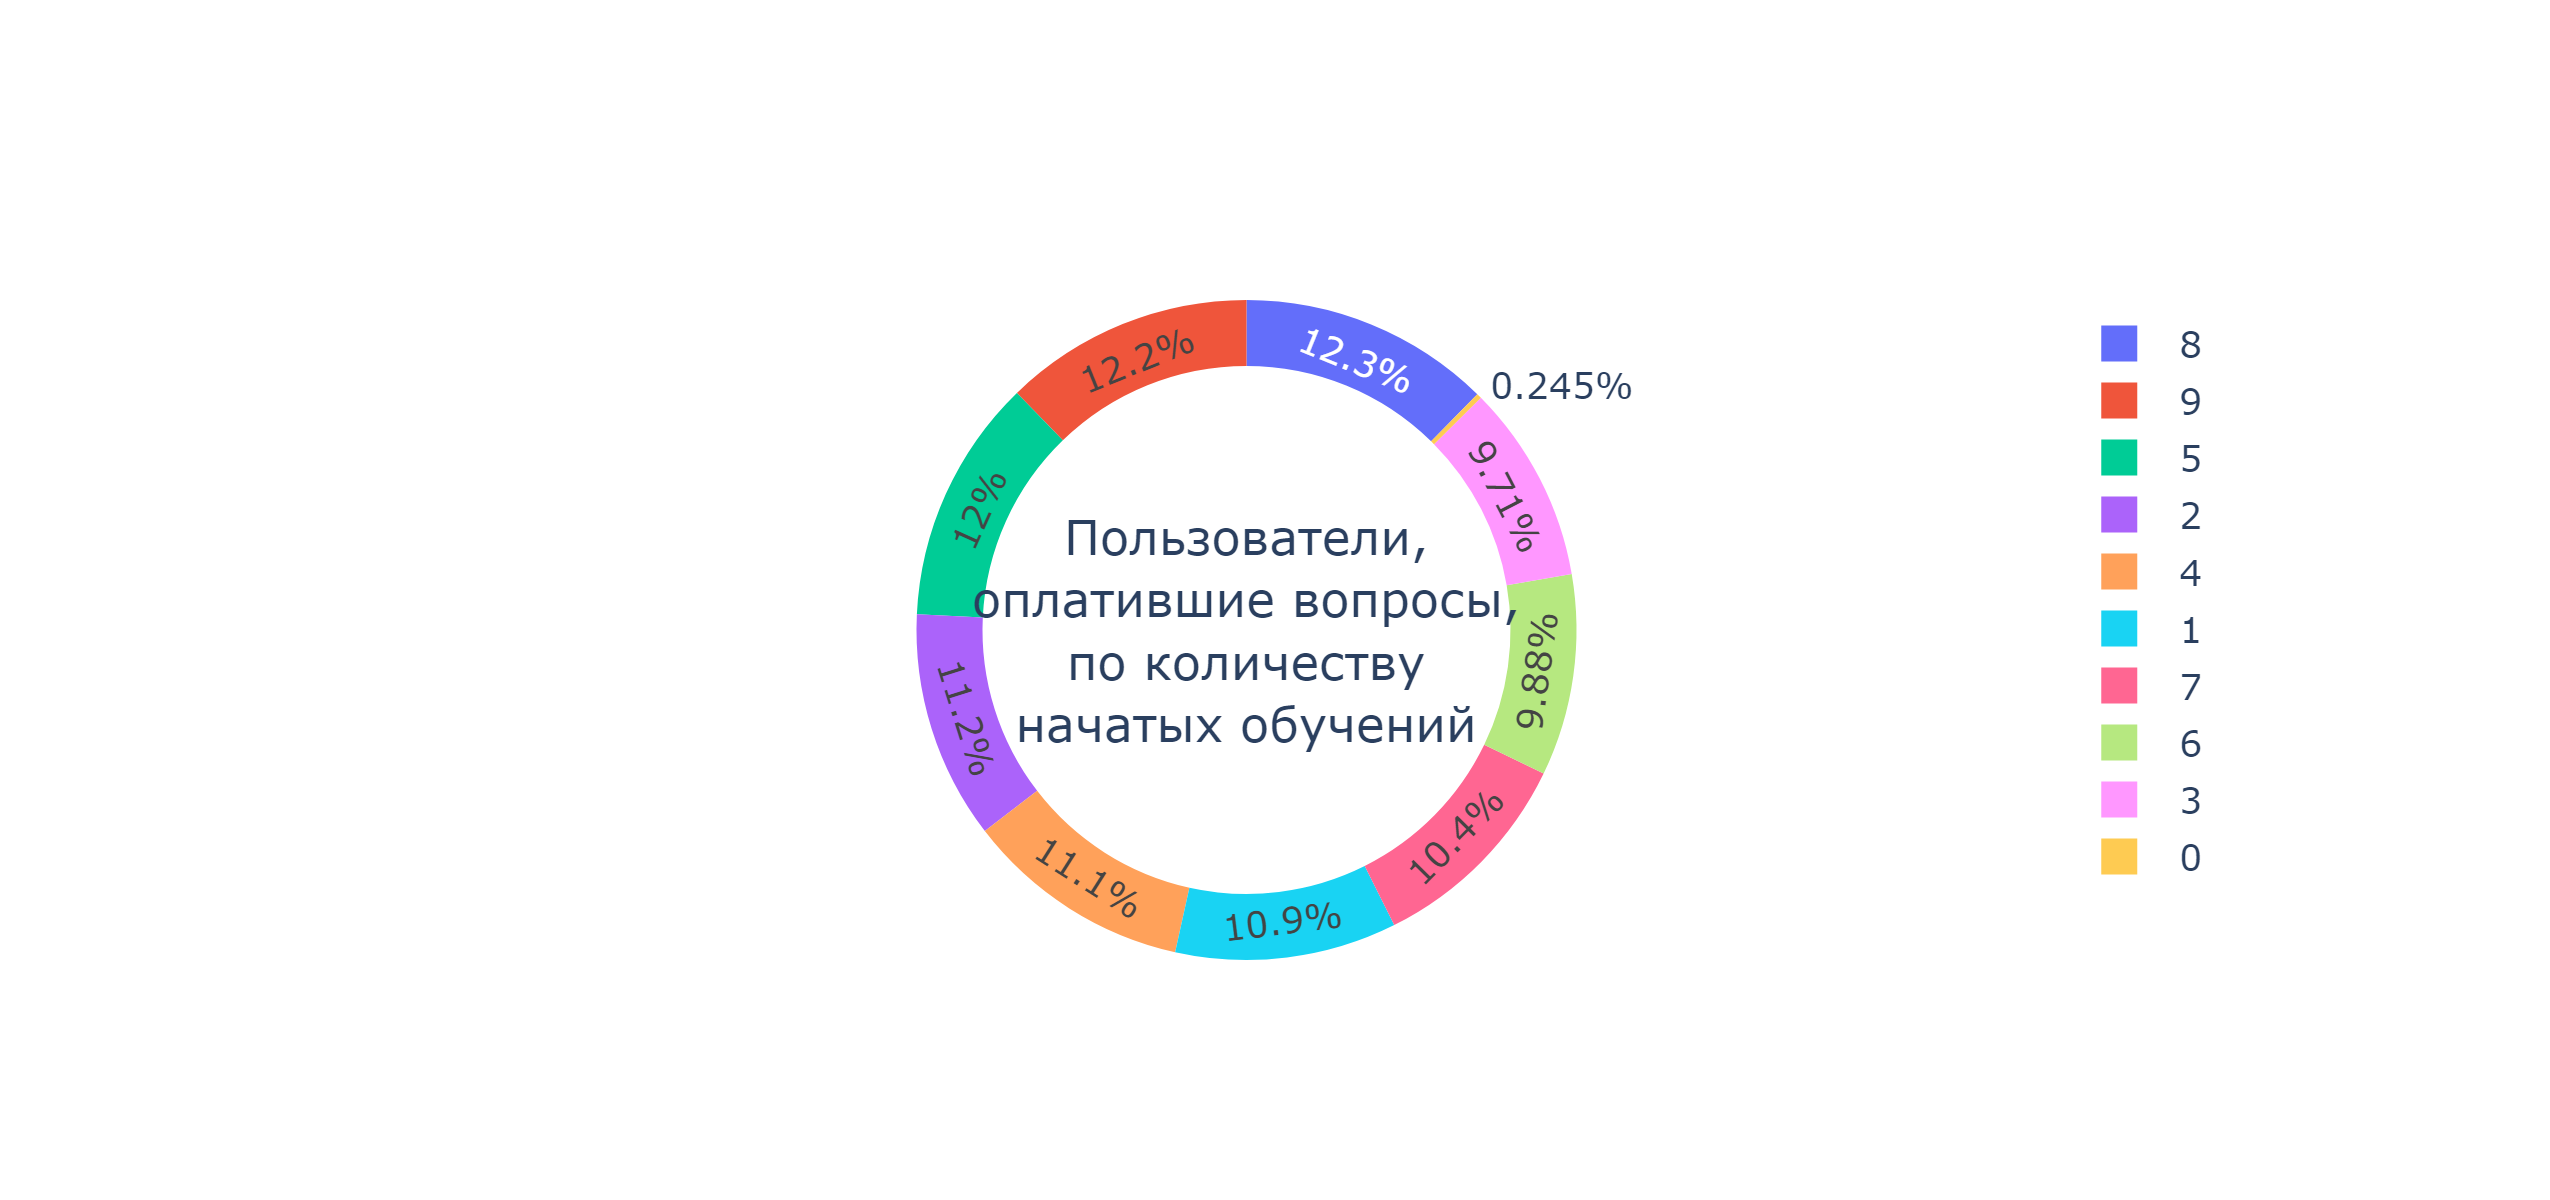

In [32]:
# своддим данные для круговой диаграммы
pie_data = start_pivot[['tutorial_start_count', 'conversion_rate']]

# создаем круговую диаграмму, оплативших вопросы пользователей, 
# по группам по количеству начатых обучений
fig = go.Figure()
fig.add_trace(go.Pie(values=pie_data['conversion_rate'], labels=pie_data['tutorial_start_count'], hole=0.8))

fig.update_layout(
    annotations=[dict(
        text='Пользователи,<br>оплатившие вопросы,<br>по количеству<br>начатых обучений', 
        x=0.5, y=0.5, font_size=16, showarrow=False)]
)

img = fig.to_image(format="png", width=850, height=400, scale=3, engine="orca")
Image(img)

Анализ конверсии пользоватлей по группам по количеству начатых обучений показывает, что конверсия пользователей равномерна по группам. 
Медианный процент пользователей, которые дошли до последнего этапа - покупки, составляет 13,45%.

Выпадом и минимальным значением является пользователи, котрые не начинали обучение. Среди них лишь 0,03% дошли до этапа оплаты.

In [33]:
# создаем сводную таблицу с данными о пользователях по группам по 
# количеству завершенных обучений и их прохождении этапов приложения
finish_pivot = pd.pivot_table(
    data=merged_df,
    values=['user_id'],
    columns=['event_type'],
    index=['tutorial_finish_count'],
    aggfunc='nunique'
)
finish_pivot.columns = list(
    map(lambda x: x[-1], finish_pivot)
)
finish_pivot = finish_pivot.reset_index()

# создаем признак конверсии пользователей по группам по количеству 
# завершенных обучений с этапа регистрации на этап оплаты вопросов
finish_pivot['conversion_rate'] = round(
    finish_pivot['purchase'] / finish_pivot['registration'], 3)
finish_pivot

,tutorial_finish_count,registration,tutorial_start,tutorial_finish,level_choice,pack_choice,purchase,conversion_rate
0,0.0,9676,1608,0,841,561,153,0.016
1,1.0,8015,8015,8015,5919,4102,1143,0.143
2,2.0,1321,1321,1321,933,644,182,0.138
3,3.0,345,345,345,235,152,44,0.128
4,4.0,178,178,178,121,70,19,0.107
5,5.0,117,117,117,87,62,19,0.162
6,6.0,101,101,101,74,49,15,0.149
7,7.0,97,97,97,76,56,15,0.155
8,8.0,54,54,54,40,28,6,0.111
9,9.0,22,22,22,16,13,4,0.182


In [34]:
# выводим статистику конверсии
finish_pivot['conversion_rate'].describe()

count    10.000000
mean      0.129100
std       0.045739
min       0.016000
25%       0.115250
50%       0.140500
75%       0.153500
max       0.182000
Name: conversion_rate, dtype: float64

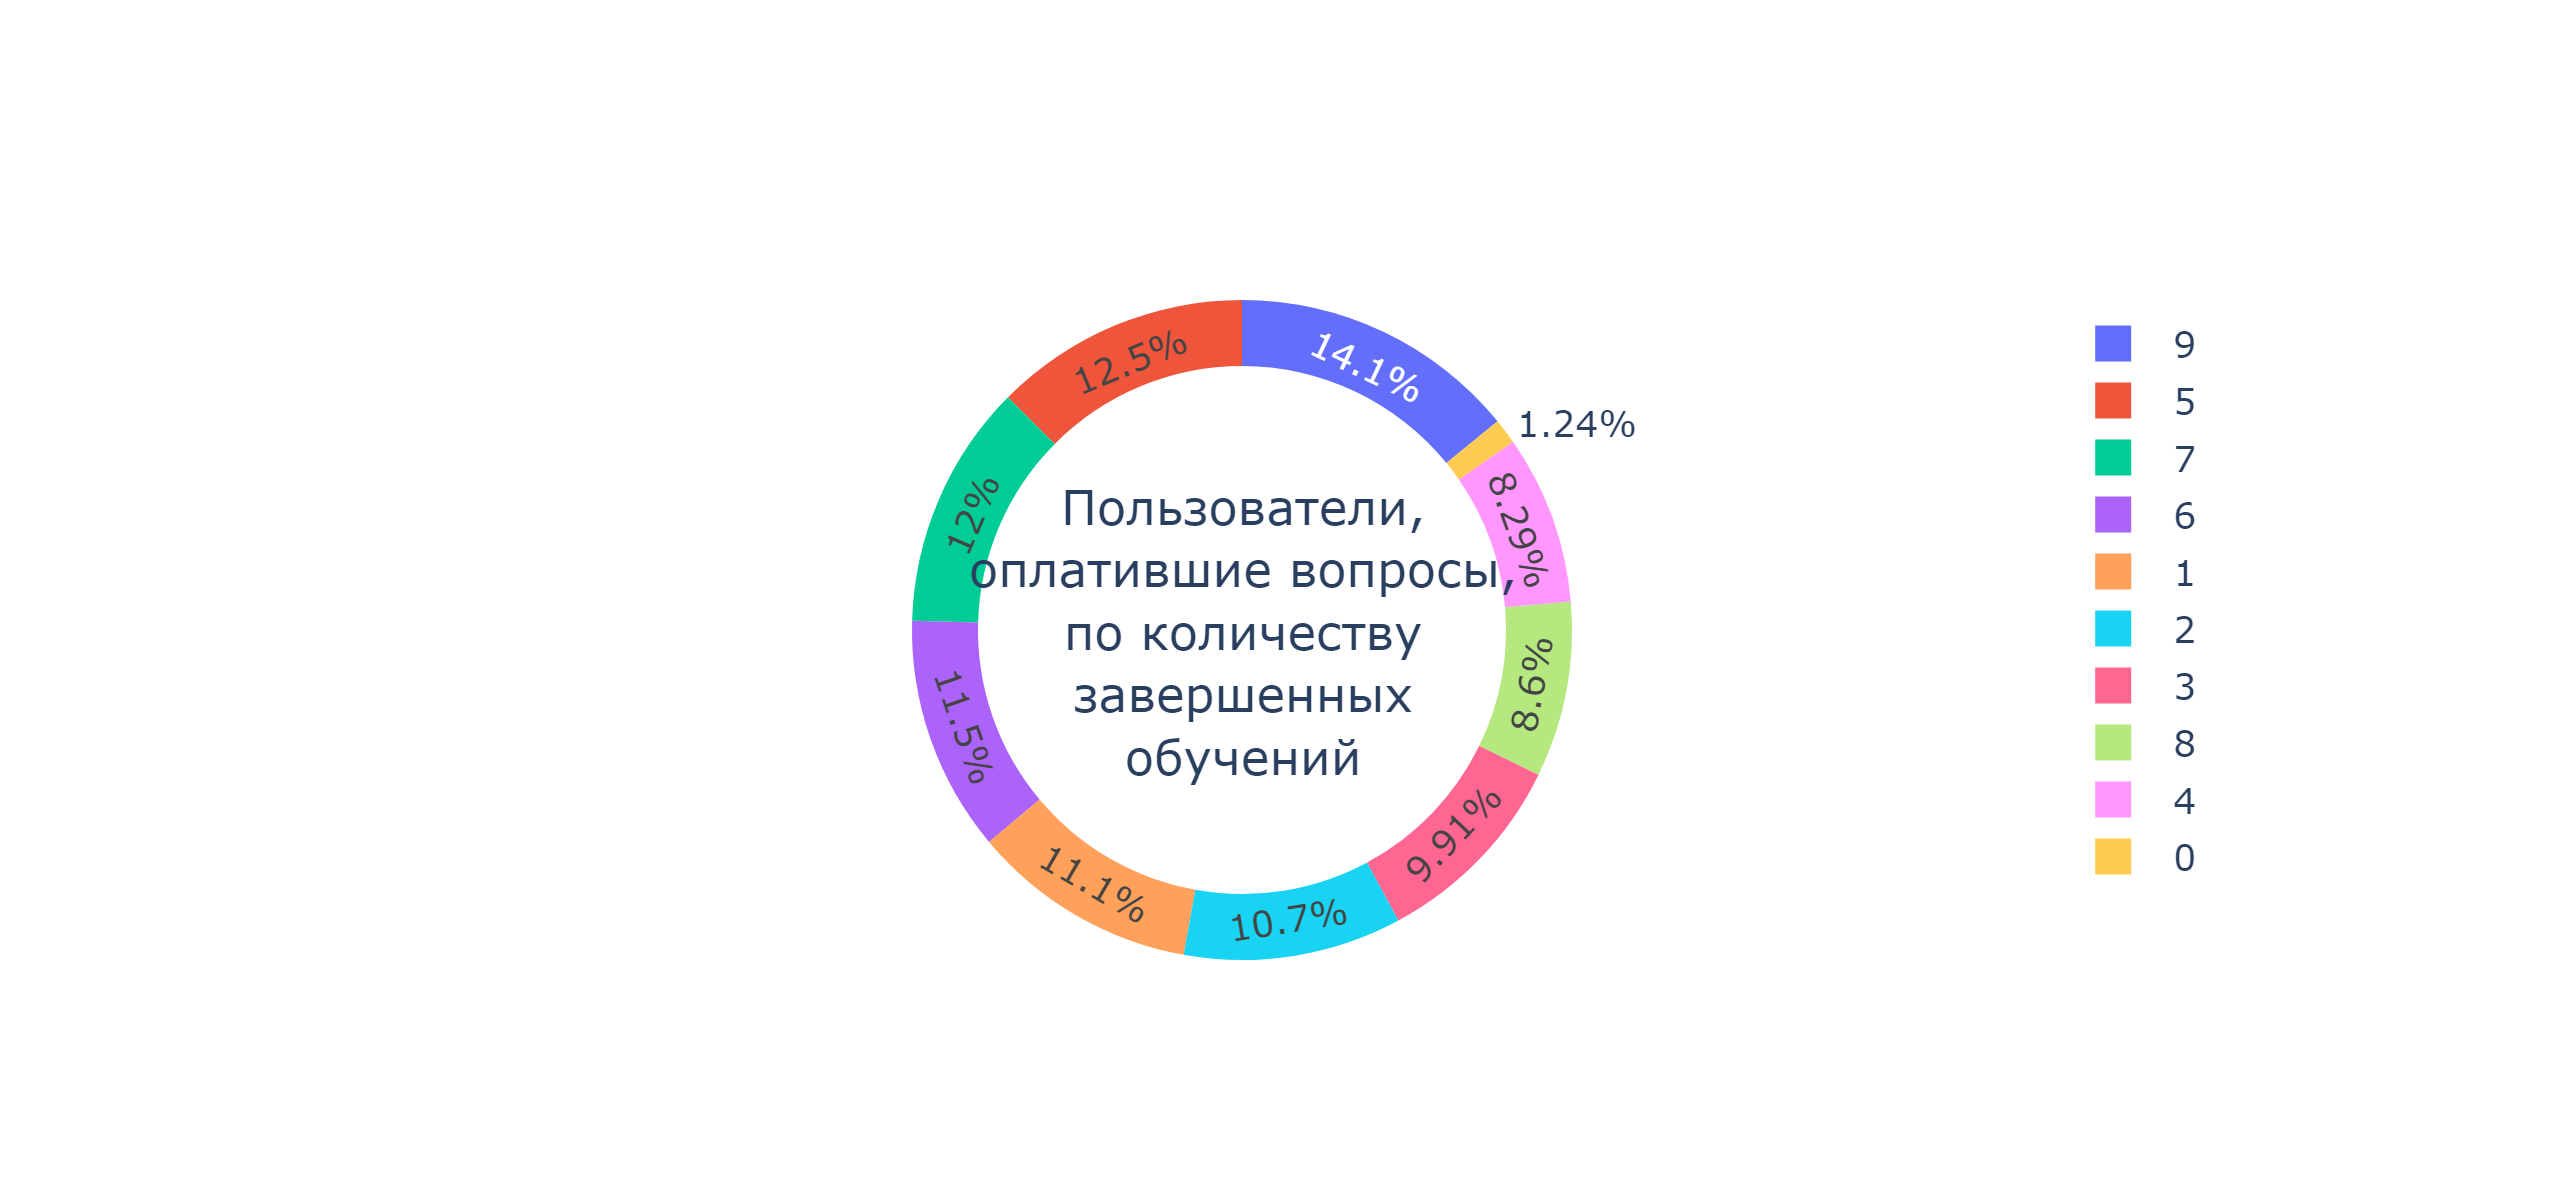

In [35]:
# сводим данные для построения круговой диаграммы
pie_data_2 = finish_pivot[['tutorial_finish_count', 'conversion_rate']]

# создаем круговую даиграмму с пользователями, оплатившими вопросы, 
# по группам по количеству завершенных обучений
fig = go.Figure()
fig.add_trace(go.Pie(values=pie_data_2['conversion_rate'], labels=pie_data_2['tutorial_finish_count'], hole=0.8))

fig.update_layout(
    annotations=[dict(
        text='Пользователи,<br>оплатившие вопросы,<br>по количеству<br>завершенных<br>обучений', 
        x=0.5, y=0.5, font_size=16, showarrow=False)]
)

img = fig.to_image(format="png", width=850, height=400, scale=3, engine="orca")
Image(img)

Конверсия пользователей по группам по количеству завершенных обучений также довольно равномерна. 
Медианный процент пользователей, котрые дошли до этапа оплаты, по группам - 14,05%. Что выше, меддианного значения конверсии пользователей по группам по количеству начатых обучений. Что говорит о том, что именно успешное обучение больше влияет на вероятность оплаты.

Также выпадом является процент пользователей, которые оплатили вопросы, но не проходили обучение - 1,6%. 

## Выводы по Гипотезе 2

Анализ прохождения пользователями по группам по количеству начатых/завершенных обучений показывает, что конверсия пользователей начинавших и завершившивших обучение в общем равномерна. Медианное значение пользователей, которые доходят до этапа покупки платных вопросов, составляет 13,45% по группам по количеству начатах обучений и 14,05% по группам по количеству завершенных обучений. Процент пользователей, которые завершили обучение, больше. Что говорит о том, что успешное обучение само по себе влияет на вероятность покупки пользователем платных вопросов не зависимо от количества пройденных обучений и каким этапом по порядку было обучение. 

Таким образом, при том что лишь 8% пользователей совершают покупку вопросов, необходимо рассмотреть варианты вовлечения пользователей в прохождение обучения.

# Проверка Гипотезы 3

## 3.1 Для проверки Гипотезы о том, что проходят ли пользователи обучение после выборы уровня сложности, определим пользователей, время начала обучения которых наступило после выбора уровня сложности, и рассмотрим их пути прохождения приложения

In [36]:
# создаем сводную таблицу со временем, когда
# пользователи в последний раз проходили этапы приложения
time_pivot_2 = df.pivot_table(
    values=['start_time'],
    index=['user_id'],
    columns=['event_type'],
    aggfunc='max'
)
time_pivot_2.columns = list(
    map(lambda x: x[-1], time_pivot_2)
)
time_pivot_2 = time_pivot_2.reset_index()

time_pivot_2.head()

,user_id,registration,tutorial_start,tutorial_finish,level_choice,pack_choice,purchase
0,27832,2018-01-01 03:48:40,NaT,NaT,NaT,NaT,NaT
1,27833,2018-01-01 04:07:25,2018-01-01 17:47:40,2018-01-01 17:50:08,NaT,NaT,NaT
2,27834,2018-01-01 08:35:10,2018-01-01 19:46:11,2018-01-01 19:48:01,NaT,NaT,NaT
3,27835,2018-01-01 11:54:47,2018-01-01 15:00:51,2018-01-01 15:06:15,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT
4,27836,2018-01-01 13:28:07,2018-01-01 15:40:43,2018-01-01 15:42:58,NaT,NaT,NaT


In [37]:
# создаем признак разницы времени между этапами выбора
# уровня сложности и началом обучения
time_pivot_2['lvl_tutorial_timedelta'] = time_pivot_2['tutorial_start'] - time_pivot_2['level_choice']
# положительная разница говорит о том, 
# что пользователи вернулись к этапу обучения после
# выбора уровня сложности
tutorial_after_lvl_choice_users_list = time_pivot_2[
    time_pivot_2['lvl_tutorial_timedelta'] > pd.to_timedelta(0)
]['user_id'].unique()

print('Количество пользователей, \
которые вернулись к этапу обучения после этапа выбора уровня сложности\
:', len(tutorial_after_lvl_choice_users_list)
)

print('Процент пользователей, \
котрые вернулись к этапу обучения после этапа выбора уровня сложности, \
от общего числа пользователей: {:.2%}'.format(
    len(tutorial_after_lvl_choice_users_list)/all_users_cnt)
)

Количество пользователей, которые вернулись к этапу обучения после этапа выбора уровня сложности: 1386
Процент пользователей, котрые вернулись к этапу обучения после этапа выбора уровня сложности, от общего числа пользователей: 6.96%


Примерно 7% пользователей вернулись к этапу начала обучения после выбора уровня сложности. Можно предположить, что этим пользователям не понятно как взаимодествовать с приложением Quiz Freeze.

In [38]:
# создаем DataFrame с данными о пользователях
# и их путях прохождения этапов приложения
user_path_df = (
    df.groupby(
        ['user_id']
    )['event_type'].apply(list).reset_index()
)
# создаем новый признак, 
# в котором преобразуем путь
user_path_df['event_path'] = user_path_df['event_type'].apply(lambda x: ' > '.join(x))
tutorial_after_lvl_choice_paths_df = user_path_df[user_path_df['user_id'].isin(tutorial_after_lvl_choice_users_list)]
# определяем уникальные пути прохождения 
# этапов приложения и количество пользователей пути прошедшие
tutorial_after_lvl_choice_paths = (
    tutorial_after_lvl_choice_paths_df.groupby(
        ['event_path'])['user_id'].nunique().sort_values(ascending=False)
)
tutorial_after_lvl_choice_paths.nlargest()

event_path
registration > tutorial_start > tutorial_finish > level_choice > pack_choice > tutorial_start > tutorial_finish               236
registration > tutorial_start > tutorial_finish > level_choice > tutorial_start > tutorial_finish                             169
registration > tutorial_start > tutorial_finish > level_choice > pack_choice > tutorial_start > tutorial_finish > purchase    101
registration > tutorial_start > tutorial_finish > level_choice > pack_choice > tutorial_start                                  53
registration > tutorial_start > tutorial_finish > level_choice > tutorial_start                                                39
Name: user_id, dtype: int64

In [39]:
lvl_choice_after_registration_paths = tutorial_after_lvl_choice_paths[
    tutorial_after_lvl_choice_paths.index.str.contains('registration > level_choice')
]
print('Количество пользователей, которые приступили к выбору сложности \
сразу после регистрации, среди тех кто проходил обучение после выбора \
уровня сложност:', lvl_choice_after_registration_paths.shape[0])

Количество пользователей, которые приступили к выбору сложности сразу после регистрации, среди тех кто проходил обучение после выбора уровня сложност: 0


Среди пользователей, которые начинали обучение после выбора уровня сложности, нет пользователей, которые приступили к выбору уровня сразу после регистрации. Значит пользователя понятно, что за этапом регистрации идет этап начала обучения.
Таким образом, те кто начал обучение после выбора уровня сложности, вернулись к началу обучения повторно. Т.е. эти пользователи либо уже наачинали обучение, либо его закончили.

In [40]:
ttrl_after_lvl_choice_purchase_paths = tutorial_after_lvl_choice_paths[
    tutorial_after_lvl_choice_paths.index.str.contains('purchase')
]
print('Количество пользователей, которые оплатили тренировки \
после повтороного обуения после выбора уровня сложности:\
', ttrl_after_lvl_choice_purchase_paths.sum()
)
print('Процент пользователей, которые оплатили платные вопросы \
после повторного обучения после выбора уровня сложности: \
{:.2%}'.format(ttrl_after_lvl_choice_purchase_paths.sum()/tutorial_after_lvl_choice_paths.sum())
)                                                             

Количество пользователей, которые оплатили тренировки после повтороного обуения после выбора уровня сложности: 265
Процент пользователей, которые оплатили платные вопросы после повторного обучения после выбора уровня сложности: 19.12%


## Вывобы по Гипотезе 3



Рассмотрение путей взаимодействия пользователей с приложением показывает, что есть пользователи, которые приступили к этапу обучения после этапа выбора уровня сложности. Однако, среди этих пользователей нет тех, кто выбрал уровень сложности сразу после регистрации. Это говорит о том, что пользователи понимают как взаимодействовать с приложением. Это также говорит о том, что те кто приступил к обучени после вбора уровня, сделали это повторно.

Количество пользователей, которые приступили повторно к обучению, составляет 7% от общего числа пользователей. При том, что всего 8% пользователей оплатили платные вопросы, 7% это большое количество.

Возможно этим пользователям что-то не понятно на этапе обучения.